In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
df = pd.read_csv("../input/superstore-csv/Superstore.csv",  encoding='cp1252')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


### Write a wrangle function that do the following:

1. Replace spaces / hyphen with underscores and lowercase labels
2. Subset only observations where the profit is greater than 0 and discount is less than 0.5.
3. removing outliers in profit
4. Convert "order_date" and "ship_date" to datetime
5. Calculate the lag time between the "order_date" and the "ship_date"
6. Create separate "year" and "month" columns
7. Drop columns containing low- or high-cardinality categorical values.
8. Drop any columns that would constitute leakage for the target "price_aprox_usd".
9. Drop any columns that would create issues of multicollinearity.
10. Drop extraneous columns.

In [3]:
def wrangle(filepath):
    df = pd.read_csv(filepath, encoding='cp1252')
    
    # replace spaces / hyphen with underscores and lowercase labels
    df.rename(columns=lambda x: x.strip().lower().replace(" ", "_").replace("-", "_"), inplace=True)

    # Initiate columns to drop
    to_drop = ["row_id", "order_id", "postal_code", "product_id", "customer_id", "customer_name"]
    
    # Subset only observations where the profit is greater than 0 and discount is less than 0.5
    mask_profit = df["profit"] > 0
    mask_discount = df["discount"] < 0.5
    
    # Subset: removing outliers in profit
    lower, higher = df["profit"].quantile([1e-6,0.9])
    mask_outlier = df["profit"].between(lower, higher)
    
    # Subset dateframe using mask
    df = df[mask_profit & mask_discount & mask_outlier]
    
    # Conver "order_date" and "ship_date" to datetime
    df["order_date"] = pd.to_datetime(df["order_date"])
    df["ship_date"] = pd.to_datetime(df["ship_date"])
    
    # Calculate the difference between the "order_date" and the "ship_date"
    df["lag_time"] = (df["ship_date"] - df["order_date"]) / np.timedelta64(1, 'D')
    
    # Create separate year and month columns from order_date
    df["year"] = df["order_date"].dt.year
    df["month"] = df["order_date"].dt.month
    
    # Add to "to_drop columns"
    to_drop = to_drop + ["order_date", "ship_date"]
    
    # Drop categorical values with high or low cardinarlity and add to "to_drop columns"
    to_drop = to_drop + ["city", "product_name", "country"]
    
    # Drop leaky columns
    to_drop = to_drop +["sales"]  
    
    # Drop extraneous columns
    df = df.drop(columns = to_drop)
    
    return df

In [4]:
# Use this cell to test your wrangle function and explore the data
df = wrangle("../input/superstore-csv/Superstore.csv")
print(df.shape)
df.head()

(7058, 12)


,ship_mode,segment,state,region,category,sub_category,quantity,discount,profit,lag_time,year,month
0,Second Class,Consumer,Kentucky,South,Furniture,Bookcases,2,0.0,41.9136,3.0,2016,11
2,Second Class,Corporate,California,West,Office Supplies,Labels,2,0.0,6.8714,4.0,2016,6
4,Standard Class,Consumer,Florida,South,Office Supplies,Storage,2,0.2,2.5164,7.0,2015,10
5,Standard Class,Consumer,California,West,Furniture,Furnishings,7,0.0,14.1694,5.0,2014,6
6,Standard Class,Consumer,California,West,Office Supplies,Art,4,0.0,1.9656,5.0,2014,6


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7058 entries, 0 to 9993
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ship_mode     7058 non-null   object 
 1   segment       7058 non-null   object 
 2   state         7058 non-null   object 
 3   region        7058 non-null   object 
 4   category      7058 non-null   object 
 5   sub_category  7058 non-null   object 
 6   quantity      7058 non-null   int64  
 7   discount      7058 non-null   float64
 8   profit        7058 non-null   float64
 9   lag_time      7058 non-null   float64
 10  year          7058 non-null   int64  
 11  month         7058 non-null   int64  
dtypes: float64(3), int64(3), object(6)
memory usage: 716.8+ KB


In [6]:
df.describe()

,quantity,discount,profit,lag_time,year,month
count,7058.000000,7058.000000,7058.000000,7058.000000,7058.000000,7058.000000
mean,3.600737,0.084996,18.708219,3.959195,2015.726268,7.803769
std,2.107864,0.099457,20.220495,1.753082,1.124347,3.278816
min,1.000000,0.000000,0.062800,0.000000,2014.000000,1.000000
25%,2.000000,0.000000,4.581600,3.000000,2015.000000,5.000000
50%,3.000000,0.000000,10.444500,4.000000,2016.000000,9.000000
75%,5.000000,0.200000,25.018200,5.000000,2017.000000,11.000000
max,14.000000,0.400000,89.222400,7.000000,2017.000000,12.000000


###  Create a histogram showing the distribution of storr profit ("profit") in df.

What does the distribution of price look like? Is the data normal, a little skewed, or very skewed?

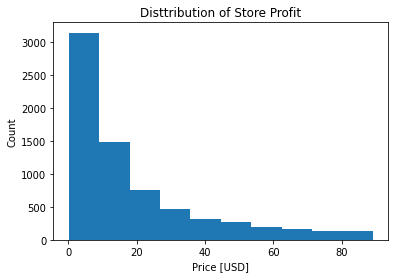

In [7]:
# Plot distribution of price
plt.hist(df["profit"])
plt.xlabel("Price [USD]")
plt.ylabel("Count")
plt.title("Disttribution of Store Profit");

### Check for cardinality

In [8]:
df.select_dtypes("object")

,ship_mode,segment,state,region,category,sub_category
0,Second Class,Consumer,Kentucky,South,Furniture,Bookcases
2,Second Class,Corporate,California,West,Office Supplies,Labels
4,Standard Class,Consumer,Florida,South,Office Supplies,Storage
5,Standard Class,Consumer,California,West,Furniture,Furnishings
6,Standard Class,Consumer,California,West,Office Supplies,Art
...,...,...,...,...,...,...
9989,Second Class,Consumer,Florida,South,Furniture,Furnishings
9990,Standard Class,Consumer,California,West,Furniture,Furnishings
9991,Standard Class,Consumer,California,West,Technology,Phones
9992,Standard Class,Consumer,California,West,Office Supplies,Paper


In [9]:
df.select_dtypes("object").nunique()

ship_mode        4
segment          3
state           48
region           4
category         3
sub_category    17
dtype: int64

### Checking for leakage

In [10]:
sorted(df.columns)

['category',
 'discount',
 'lag_time',
 'month',
 'profit',
 'quantity',
 'region',
 'segment',
 'ship_mode',
 'state',
 'sub_category',
 'year']

### Checking for co-linearity in our features

In [11]:
corr = df.select_dtypes("number").drop(columns = ["profit"]).corr()
corr

,quantity,discount,lag_time,year,month
quantity,1.000000,0.021811,0.031944,0.003804,0.016916
discount,0.021811,1.000000,-0.015134,0.001409,0.013870
lag_time,0.031944,-0.015134,1.000000,-0.028745,0.005362
year,0.003804,0.001409,-0.028745,1.000000,-0.010767
month,0.016916,0.013870,0.005362,-0.010767,1.000000


In [12]:
sns.heatmap(corr)

NameError: name 'sns' is not defined

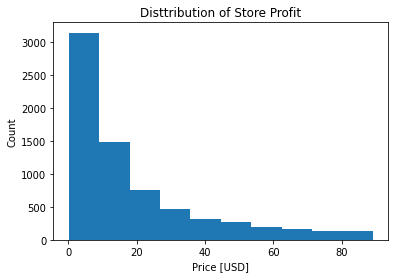

In [13]:
# Plot distribution of price
plt.hist(df["profit"])
plt.xlabel("Price [USD]")
plt.ylabel("Count")
plt.title("Disttribution of Store Profit");

- Create a scatter plot that shows apartment price (`"price_aprox_usd"`) as a function of apartment size (`"surface_covered_in_m2"`).
- Any relationship between price and area in the data?

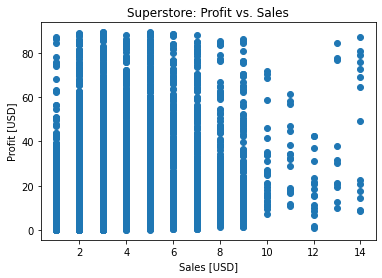

In [14]:
# Plot price vs area
plt.scatter(x = df["quantity"], y = df["profit"])
plt.xlabel("Sales [USD]")
plt.ylabel("Profit [USD]")
plt.title("Superstore: Profit vs. Sales");

## Split

- Create the feature matrix `X` and target vector `y`. Your target is `"profit"`.

In [15]:
# Split data into feature matrix `X` and target vector `y`.
target = "profit"
X = df.drop(columns = [target])
y = df[target]

print(X.shape)
print(y.shape)

(7058, 11)
(7058,)


- Divide your data (`X` and `y`) into training and test sets using a randomized train-test split. Set test to 20% of the total data. And don't forget to set a `random_state` for reproducibility.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size = 0.2, random_state = 42
    )

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (5646, 11)
y_train shape: (5646,)
X_test shape: (1412, 11)
y_test shape: (1412,)


## Build Model

## Baseline

In [17]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred_baseline)
print("Mean store profit:", y_mean)
print("Baseline MAE:", baseline_mae)

Mean store profit: 18.780684998228836
Baseline MAE: 15.505115385511127


### Iterate

Create a pipeline named `model` that contains all the required transformers and fit the model

In [18]:
# Build Model
model = make_pipeline(
        OneHotEncoder(use_cat_names=True),
        LinearRegression()
)
# Fit model
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['ship_mode', 'segment', 'state', 'region',
                                     'category', 'sub_category'],
                               use_cat_names=True)),
                ('linearregression', LinearRegression())])

### Evaluate

## Predict

Use model to generate a Series of predictions for X_test.

In [19]:
y_test_pred = pd.Series(model.predict(X_test))
y_test_pred.head()

0    11.512731
1    15.048419
2    49.745109
3    -2.698972
4     7.845110
dtype: float64

In [20]:
baseline_mae = mean_absolute_error(y_train, y_pred_baseline)
print("Mean store profit:", y_mean)
print("Baseline MAE:", baseline_mae)

Mean store profit: 18.780684998228836
Baseline MAE: 15.505115385511127


In [21]:
mae_train = mean_absolute_error(y_train, y_pred_baseline)
mae_test = mean_absolute_error(y_test, y_test_pred)

print("Baseline MAE:", round(mae_train, 4))
print("Test MAE:", round(mae_test, 4))

Baseline MAE: 15.5051
Test MAE: 12.5337


### Communicate Result

Create a Series named `feat_imp`.

In [22]:
coefficients = model.named_steps["linearregression"].coef_
features = model.named_steps["onehotencoder"].get_feature_names()
feat_imp = pd.Series(coefficients, index = features)
feat_imp

ship_mode_Standard Class     1.197155
ship_mode_Second Class       0.092642
ship_mode_Same Day          -1.390236
ship_mode_First Class        0.100438
segment_Consumer             0.177234
                              ...    
quantity                     2.717447
discount                   -39.898737
lag_time                    -0.566498
year                        -0.110075
month                       -0.054198
Length: 84, dtype: float64

 Create a horizontal bar chart that shows the 10 most influential coefficients for the model.

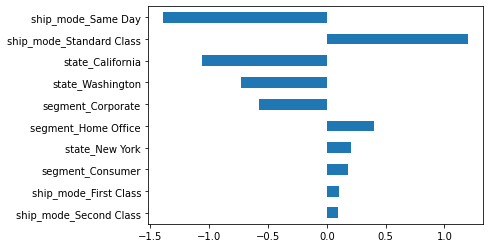

In [23]:
# Create horizontal bar chart
feat_imp.head(10).sort_values(key= abs).plot(kind= "barh")
plt.savefig("top10_feat", dpi=150);

### Save model

In [24]:
# Save model
with open("superstore_model", "wb") as f:
    pickle.dump(model, f)

In [25]:
def make_predictions(data_filepath, model_filepath):
    # Wrangle data
    X_test = wrangle(data_filepath)
    # Drop target if present
    for name in X_test.columns:
        if name == "profit":
            X_test.drop(columns = ["profit"], inplace = True)
    # Load model
    with open(model_filepath, "rb") as f:
        model = pickle.load(f)
    # Generate predictions
    y_test_pred = model.predict(X_test)
    # Put predictions into Series with name "profit", and same index as X_test
    y_test_pred = pd.Series(y_test_pred, index = X_test.index, name = "profit")
    return y_test_pred

### Test function

In [26]:
make_predictions("../input/superstore-csv/Superstore.csv", "./superstore_model")

0       36.947135
2        6.801745
4        7.245145
5       28.986897
6       10.927379
          ...    
9989    12.487052
9990    15.286228
9991    22.258305
9992    21.969505
9993    21.262789
Name: profit, Length: 7058, dtype: float64